In [1]:
import sim
import time
import cv2
import numpy as np
from PIL import Image
from queue import PriorityQueue
import math
from numpy import sqrt
import itertools

In [2]:
def resize(img,resolution):
    scale_percent = 500 # percent of original size
    width = int(resolution[1] * scale_percent / 100)
    height = int(resolution[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized
def x_w_i(w_x):
    y=((w_x+2.5)*1280)/5
    return round(y)
def y_w_i(w_y):
    x=((2.5-w_y)*1280)/5
    return round(x)
def x_i_w(i_x):
    y=(i_x*5/1280)-2.5
    return y
def y_i_w(i_y):
    x=(2.5)-(i_y*5/1280)
    return x
def draw_rec_red(x,image):
    for i in range(120):
         for j in range(120):
                if (0<x[0]-60+i<1280 and 0<x[1]-60+j<1280):
                    image[x[0]-60+i][x[1]-60+j]=(255,0,0)

def draw_rec_blue(x,image): 
    for i in range(120):
         for j in range(120):
                if (0<x[0]-60+i<1280 and 0<x[1]-60+j<1280):
                    image[x[0]-60+i][x[1]-60+j]=(0,0,255)
                    
                    
def draw_rec_green(x,image):
    for i in range(120):
         for j in range(120):
                if (0<x[0]-60+i<1280 and 0<x[1]-60+j<1280):
                    image[x[0]-60+i][x[1]-60+j]=(0,255,0)
                    
                    
def my_range(start, end, step):
    while start <= end:
        yield start
        start += step

def obstacles_grid(img):
    # getting the walls 
    mask_wall = cv2.inRange(img, np.array([228,228,253]),np.array([230,230,2256]))
    # getting the rims
    mask_rim = cv2.inRange(img, 0, 0)
    mask_total = cv2.bitwise_or(mask_wall,mask_rim,mask_rim)
    mask_total = cv2.bitwise_not(mask_total)
    return mask_total

def dist(x,y):
    dist = sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2 )
    return round(dist)


def get(array):
    array.sort()
    return array.pop(0)
    

def put(array,data):
    array.append(data)
    array.sort()
    return array

def expand(s):
    aa=[]
    for row in s:
        for a_a in row[1:]:
            aa.append(a_a)
    return aa
def man_dis(x,y):
    x1,y1=x
    x2,y2=y
    return abs(x1-x2)+abs(y1-y2)
def neighbours(x,img_obs):
    neigh=[]
    kk=[-128,0,128]
    for i in kk:
        for j in kk:
            if i==0 and j==0:
                continue
            else:
                if (0<(x[0]+i)) and ((x[0]+i)<=1280) and (0<(x[1]+j))and((x[1]+j)<=1280):
                            if img_obs[x[0]+i][x[1]+j]!=0:
                                neigh.append([x[0]+i,x[1]+j])
    return neigh
                            

In [3]:

sim.simxFinish(-1)
scale_percent =600
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)
thistime = time.time()
if clientID != -1:
    res_ro, robot = sim.simxGetObjectHandle(clientID, 'Pioneer_p3dx', sim.simx_opmode_oneshot_wait)
    res_l,right_motor_handle = sim.simxGetObjectHandle(clientID,'Pioneer_p3dx_rightMotor',sim.simx_opmode_oneshot_wait)
    res_r,left_motor_handle = sim.simxGetObjectHandle(clientID,'Pioneer_p3dx_leftMotor',sim.simx_opmode_oneshot_wait)
    res_floor,floor=sim.simxGetObjectHandle(clientID,'ResizableFloor_5_25',sim.simx_opmode_blocking)
    res,camera = sim.simxGetObjectHandle(clientID, 'ss', sim.simx_opmode_oneshot_wait)
    err, resolution, image = sim.simxGetVisionSensorImage(clientID, camera, 0, sim.simx_opmode_streaming)
    while (sim.simxGetConnectionId(clientID) != -1):
        res_pos,pos=sim.simxGetObjectPosition(clientID,robot,-1,sim.simx_opmode_oneshot_wait)
        res_or,orien=sim.simxGetObjectOrientation(clientID,robot,-1,sim.simx_opmode_oneshot_wait)
        print(pos)
        #print(orien)
        err, resolution, image = sim.simxGetVisionSensorImage(clientID, camera, 0, sim.simx_opmode_buffer)
        if err == sim.simx_return_ok:
            img = np.array(image, dtype=np.uint8)
            img.resize([resolution[0], resolution[1], 3]) 
            resized=resize(img,resolution)
            image = Image.fromarray(resized, 'RGB')
        sim.simxFinish(clientID)
img_obs = obstacles_grid(resized)
xs=x_w_i(pos[0])
ys=y_w_i(pos[1])
start=[0,[xs,ys]]
goal=[x_w_i(-2.25),y_w_i(2.25)]

[2.246544122695923, -2.2512145042419434, 0.13864685595035553]


In [7]:
#itr 1 with priority queue
closed=[]
def ucs(start,goal,resized,img_obs):
    open_l=[]
    open_l.append(start)
    while open_l:
        open_l.sort()
        node=get(open_l)
        print(node)
        node1=node[-1]
        distance=node[0]
        closed.append(node1)
        if(goal[0]-2<node1[0]<goal[0]+2 and goal[1]-2<node1[1]<goal[1]+2):
            draw_rec_green(node1,resized)
            return node
            break
        else:
            nei=neighbours(node1,img_obs)
            open_le=expand(open_l)
            s=[]
            for ne in nei:
                draw_rec_red(ne,resized)
                if ne not in open_l and ne not in closed:
                    a=node.copy()
                    a[0]=dist(node1,ne)+distance
                    a.append(ne)
                    open_l.append(a)
                    
                else:
                    for ro in open_l:
                        if ro[-1]==ne:
                            if ro[0]>(dist(node1,ne)+distance):
                                open_l.remove(ro)
                                a=node.copy()
                                a[0]=dist(node1,ne)+distance
                                a.append(ne)
                                open_l.append(a)

                
ccc=ucs(start,goal,resized,img_obs)

[0, [1215, 1216]]
[128.0, [1215, 1216], [1087, 1216]]
[128.0, [1215, 1216], [1215, 1088]]
[181.0, [1215, 1216], [1087, 1088]]
[256.0, [1215, 1216], [1087, 1216], [959, 1216]]
[256.0, [1215, 1216], [1087, 1216], [1087, 1088]]
[256.0, [1215, 1216], [1215, 1088], [1087, 1088]]
[256.0, [1215, 1216], [1215, 1088], [1215, 960]]
[309.0, [1215, 1216], [1087, 1088], [959, 1088]]
[309.0, [1215, 1216], [1087, 1088], [1087, 960]]
[309.0, [1215, 1216], [1087, 1216], [959, 1088]]
[309.0, [1215, 1216], [1087, 1216], [1215, 1088]]
[309.0, [1215, 1216], [1215, 1088], [1087, 960]]
[362.0, [1215, 1216], [1087, 1088], [959, 960]]
[362.0, [1215, 1216], [1087, 1088], [959, 1216]]
[362.0, [1215, 1216], [1087, 1088], [1215, 960]]
[384.0, [1215, 1216], [1087, 1216], [959, 1216], [959, 1088]]
[384.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 1088]]
[384.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960]]
[384.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 1088]]
[384.0, [1215, 1216], [1215, 1088

[693.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576]]
[693.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704]]
[693.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1215, 704]]
[693.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576]]
[724.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704]]
[724.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704]]
[746.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576]]
[746.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [1087, 704]]
[746.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576]]
[746.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [1087, 704]]
[746.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576]]
[746.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [

[821.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576]]
[821.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [1215, 576]]
[821.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576]]
[821.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448]]
[821.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576]]
[821.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [1215, 576]]
[821.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1087, 448]]
[852.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576]]
[852.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576]]
[852.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576]]
[852.0, [1215, 1216], [1087, 1088], [108

[927.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [1087, 448]]
[927.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [1087, 448]]
[927.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448]]
[927.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [1087, 448]]
[927.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448]]
[927.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448]]
[927.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448]]
[927.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1215, 576], [1087, 448]]
[927.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1215, 704], [1087, 576], [1087, 448]]
[927.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1215, 704], [1215, 576], [1087, 448]]
[9

[949.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1087, 576], [1215, 448]]
[949.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1087, 320]]
[980.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [1087, 576], [959, 448]]
[980.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [959, 448]]
[980.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [1087, 576], [959, 448]]
[980.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [959, 448]]
[980.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [959, 448]]
[980.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448]]
[980.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [959, 448]]
[980.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [9

[1002.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1215, 576], [1215, 448], [1215, 320]]
[1002.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1215, 704], [1215, 576], [1215, 448], [1215, 320]]
[1002.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1215, 320]]
[1002.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448]]
[1002.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448]]
[1002.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448]]
[1002.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448]]
[1002.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448]]
[1002.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 4

[1055.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [1087, 320]]
[1055.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [1087, 448], [1087, 320]]
[1055.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [1087, 448], [1087, 320]]
[1055.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320]]
[1055.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448]]
[1055.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [831, 320]]
[1055.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320]]
[1055.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [1087, 320]]
[1055.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [1087

[1055.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1215, 576], [1087, 448], [1087, 320]]
[1055.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1215, 576], [1215, 448], [1087, 320]]
[1055.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1215, 704], [1087, 576], [1087, 448], [1087, 320]]
[1055.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1215, 704], [1215, 576], [1087, 448], [1087, 320]]
[1055.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1215, 704], [1215, 576], [1215, 448], [1087, 320]]
[1055.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448]]
[1055.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [831, 320]]
[1055.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 320]]
[1055.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [

[1077.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320]]
[1077.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320]]
[1077.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1215, 320]]
[1077.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [959, 448], [959, 320]]
[1077.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448], [959, 448], [959, 320]]
[1077.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448], [1087, 320], [959, 320]]
[1077.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192]]
[1077.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [959, 448], 

[1108.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [959, 320]]
[1108.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448], [959, 320]]
[1108.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1087, 448], [959, 320]]
[1108.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320]]
[1108.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576]]
[1108.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [959, 320]]
[1108.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [1087, 448], [959, 320]]
[1108.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [959, 448], [959, 320]]
[1108.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [1087, 448], [959, 3

[1130.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [959, 448], [1087, 320]]
[1130.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448]]
[1130.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [831, 320]]
[1130.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 320]]
[1130.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [959, 192]]
[1130.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448]]
[1130.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [831, 320]]
[1130.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [959, 448], [831, 320]]
[1130.0,

[1130.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448]]
[1130.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [831, 320]]
[1130.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [831, 320]]
[1130.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [959, 192]]
[1130.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448]]
[1130.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [831, 320]]
[1130.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [959, 448], [831, 320]]
[1130.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [831, 320]]

[1130.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448]]
[1130.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320]]
[1130.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320]]
[1130.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320]]
[1130.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448]]
[1130.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [831, 320]]
[1130.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 320]]
[1130.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [959, 192]]
[11

[1152.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1087, 448], [1087, 320], [1087, 192]]
[1152.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1215, 320], [1087, 320], [1087, 192]]
[1152.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1215, 320], [1215, 192], [1087, 192]]
[1152.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1215, 320], [1215, 192], [1215, 64]]
[1161.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [1087, 576], [959, 448], [831, 320]]
[1161.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448]]
[1161.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [831, 320]]
[1161.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [959, 448], [831, 320

[1183.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576]]
[1183.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 320]]
[1183.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192]]
[1183.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 320]]
[1183.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192]]
[1183.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 320]]
[1183.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576]]
[1183.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 192]]
[1183.0, [1215, 1216], [

[1183.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1215, 576], [1215, 448], [1215, 320], [1087, 192]]
[1183.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192]]
[1183.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192]]
[1183.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1215, 704], [1215, 576], [1087, 448], [1087, 320], [1087, 192]]
[1183.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1087, 320], [1087, 192]]
[1183.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1215, 320], [1087, 192]]
[1183.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192]]
[1183.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [1087, 448], [1

[1183.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 320]]
[1183.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576]]
[1183.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [703, 320]]
[1183.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [831, 192]]
[1183.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 320]]
[1183.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576]]
[1183.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [831, 192]]
[1183.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [1087, 192]]
[

[1183.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576]]
[1183.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [703, 320]]
[1183.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [831, 192]]
[1183.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 320]]
[1183.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576]]
[1183.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [831, 192]]
[1183.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [1087, 192]]
[1183.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [1087, 320], [1087, 192]

[1183.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 448], [703, 320]]
[1183.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 448], [703, 576]]
[1183.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [959, 320], [831, 192]]
[1183.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [959, 320], [1087, 192]]
[1183.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [1087, 320], [1087, 192]]
[1183.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 320]]
[1183.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 576]]
[1183.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448], [959, 320], [831, 19

[1205.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [959, 192]]
[1205.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [959, 192]]
[1205.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [959, 192]]
[1205.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192]]
[1205.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1215, 192]]
[1205.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192]]
[1205.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [959, 448], [959, 320], [959, 192]]
[1205.0, [1215, 1216], [1215, 10

[1214.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576]]
[1236.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 320]]
[1236.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192]]
[1236.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 320]]
[1236.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576]]
[1236.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576]]
[1236.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704]]
[1236.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192]]
[1236.0, [1215, 1216], [1087, 1088], [959

[1236.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 320]]
[1236.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576]]
[1236.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576]]
[1236.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704]]
[1236.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [703, 192]]
[1236.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [959, 192]]
[1236.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [959, 192]]
[1236.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [703, 192]]
[1236.0,

[1236.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192]]
[1236.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [959, 192]]
[1236.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [959, 192]]
[1236.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [959, 192]]
[1236.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192]]
[1236.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 320]]
[1236.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192]]
[1236.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 320]]
[1236.0,

[1236.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [959, 320], [959, 192]]
[1236.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 192]]
[1236.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [959, 192]]
[1236.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [1087, 320], [959, 192]]
[1236.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [959, 320], [959, 192]]
[1236.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [1087, 320], [959, 192]]
[1236.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [959, 320], [959, 192]]
[1236.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448], [959, 320], [959, 192]]
[1236.0, 

[1258.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192]]
[1258.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192]]
[1258.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 192]]
[1258.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [1087, 192]]
[1258.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448]]
[1258.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [831, 320], [831, 192]]
[1258.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 320], [831, 192]]
[1258.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832],

[1258.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448]]
[1258.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192]]
[1258.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192]]
[1258.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 192]]
[1258.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448]]
[1258.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192]]
[1258.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192]]
[1258.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 96

[1258.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [831, 192]]
[1258.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [959, 64]]
[1258.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 320], [831, 192]]
[1258.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192], [959, 64]]
[1258.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192], [1215, 64]]
[1258.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1215, 192], [1215, 64]]
[1258.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1215, 320], [1215, 192], [1215, 64]]
[1258.0, [1215, 1216], [1

[1258.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 448], [959, 320], [831, 192]]
[1258.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [831, 192]]
[1258.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [959, 64]]
[1258.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 320], [831, 192]]
[1258.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192], [959, 64]]
[1258.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192], [1215, 64]]
[1258.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1215, 192], [1215, 64]]
[1258.0, [1215, 1216], [121

[1258.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192]]
[1258.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 192]]
[1258.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448]]
[1258.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [831, 192]]
[1258.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 192]]
[1258.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 192]]
[1258.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [831, 192]]
[1258.0, [1215, 1216], [1215, 1088], [1215

[1258.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1215, 320], [1087, 192], [1215, 64]]
[1280.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 320], [959, 192]]
[1280.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 320], [959, 192]]
[1280.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192], [1087, 64]]
[1280.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192], [1087, 64]]
[1280.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192], [1087, 64]]
[1280.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [108

[1289.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [959, 320], [831, 192]]
[1289.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [831, 320], [831, 192]]
[1289.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [959, 320], [831, 192]]
[1289.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448], [959, 320], [831, 192]]
[1289.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 192]]
[1289.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448]]
[1289.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [831, 192]]
[1289.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448]]
[1289.0

[1289.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448]]
[1289.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [831, 192]]
[1289.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448]]
[1289.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704]]
[1289.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [959, 320], [831, 192]]
[1289.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [1087, 448], [959, 320], [831, 192]]
[1289.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [831, 320], [831, 192]]
[1289.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [959, 320], [831, 192]]
[1289.0, [121

[1311.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704]]
[1311.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 320], [575, 320]]
[1311.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 320], [703, 192]]
[1311.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192], [703, 192]]
[1311.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192], [831, 64]]
[1311.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 320], [575, 320]]
[1311.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 320], [703, 192]]
[1311.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704

[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192], [1087, 64]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 320]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 320]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 9

[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 320]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [831, 320], [703, 192]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 192], [703, 192]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 192], [831, 64]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960],

[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1215, 576], [1087, 448], [1087, 320], [1087, 192], [1087, 64]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1215, 576], [1215, 448], [1087, 320], [1087, 192], [1087, 64]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1215, 576], [1215, 448], [1215, 320], [1087, 192], [1087, 64]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1215, 576], [1215, 448], [1215, 320], [1215, 192], [1087, 64]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192], [1087, 64]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1215, 576], [1087, 448], [1087, 320], [1087, 192], [1087, 64]]
[1311.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1215, 576], [1215, 448], [1087, 320], [1087, 192], [1087, 64]]
[1311.0, [1215, 1216

[1311.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [703, 192]]
[1311.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [703, 192]]
[1311.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 320]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 320], [575, 320]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 320], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960],

[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 192], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 192], [831, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 320], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192], [831, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192], [1087, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [959, 320], [1087, 192], [1087, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [1087, 320], [1087, 192], [1087, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [108

[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [703, 704]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [831, 320], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [831, 192], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [831, 192], [831, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [831, 320], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [959, 192], [831, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [959, 192], [1087, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1087,

[1311.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 320]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 320]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576]]
[1311.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576]]
[1311.0, [1215, 1216], [1215, 1088], [1087,

[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [703, 320], [575, 320]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [703, 320], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [831, 192], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [831, 192], [831, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [703, 320], [575, 320]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [703, 320], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 192], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960],

[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [959, 192], [1087, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [1087, 192], [1087, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 448], [831, 320], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [831, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [1087, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1215, 192], [1087, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1215, 320], [1087, 192], [1087, 64]]
[1311.0, [1215, 1216], [1215

[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 320]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [831, 320], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 192], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 192], [831, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960],

[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1215, 576], [1087, 448], [1087, 320], [1087, 192], [1087, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1215, 576], [1215, 448], [1087, 320], [1087, 192], [1087, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1215, 576], [1215, 448], [1215, 320], [1087, 192], [1087, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1215, 576], [1215, 448], [1215, 320], [1215, 192], [1087, 64]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 320]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 320]]
[1311.0, [1215, 1216], [1215, 10

[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 320]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 320], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 320]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704]]
[1311.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [831, 320], [703, 192]]
[1311.0, [1215, 1216], [1215, 1088], [121

[1333.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [959, 64]]
[1333.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192], [959, 64]]
[1333.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192], [1215, 64]]
[1333.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192], [959, 64]]
[1333.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192], [959, 64]]
[1333.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [959, 448], [959, 320], [959, 192], [959, 64]]
[1333.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448]

[1333.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1087, 448], [1087, 320], [1087, 192], [959, 64]]
[1333.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1087, 448], [1087, 320], [1087, 192], [1215, 64]]
[1333.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1215, 320], [1087, 192], [959, 192], [959, 64]]
[1333.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1215, 320], [1087, 192], [1087, 64], [959, 64]]
[1333.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1215, 320], [1087, 320], [959, 192], [959, 64]]
[1333.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1215, 320], [1087, 320], [1087, 192], [959, 64]]
[1333.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1215, 576], [

[1342.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 320]]
[1342.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [703, 192]]
[1342.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 320]]
[1342.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576]]
[1342.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576]]
[1342.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704]]
[1342.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [703, 192]]
[1342.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [703, 192]]
[1342.0,

[1364.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 320], [575, 192]]
[1364.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192], [703, 64]]
[1364.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192], [959, 64]]
[1364.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 320], [575, 192]]
[1364.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704]]
[1364.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 192], [703, 64]]
[1364.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], 

[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [1087, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [1087, 320], [1087, 192], [959, 64]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [1087, 448], [959, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [1087, 448], [1087, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [1087, 448], [1087, 320], [1087, 192], [959, 64]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [959, 448], [959, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [1087, 448], [959, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 8

[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 320], [575, 192]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 320], [575, 192]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960]

[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1215, 576], [1215, 448], [1215, 320], [1087, 192], [959, 64]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1087, 576], [959, 448], [959, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1087, 576], [1087, 448], [959, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1087, 576], [1087, 448], [1087, 320], [1087, 192], [959, 64]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1215, 576], [1087, 448], [959, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1215, 704], [1215, 576], [1087, 448], [1087, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1087, 1088],

[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 320], [575, 192]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], 

[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 192], [703, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 320], [575, 192]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192], [703, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192], [959, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 320], [575, 192]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 83

[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 320], [575, 192]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [831, 192], [703, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [831, 192], [959, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [1087, 192], [959, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [1087, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1087, 

[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 320], [575, 192]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1087

[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 192], [703, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 192], [959, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [1087, 192], [959, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [1087, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [1087, 320], [1087, 192], [959, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448], [959, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448], [1087, 320], [959, 192], [959, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960]

[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 320], [575, 192]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [703, 192], [575, 192]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960]

[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 192]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 320], [703, 192], [575, 192]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 320], [703, 192], [703, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 320], [703, 320], [575, 192]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 320], [831, 192], [703, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 320], [831, 192], [959, 64]]
[1364.0, [1215, 1216], [1215, 1088], [1215, 

[1386.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [959, 448], [959, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192], [831, 64]]
[1386.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192], [1087, 64]]
[1386.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [831, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [83

[1386.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192], [959, 64], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [831, 320], [831, 19

[1386.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [959, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [959, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576]

[1386.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [959, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [959, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [8

[1386.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448], [959, 448], [831, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448], [959, 448], [959, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448], [959, 448], [959, 320], [959, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [959, 64], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448], [1087, 320], [959, 320], [831, 192], [831, 64]]
[1386.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448], [1

[1395.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 192]]
[1395.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704]]
[1395.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 192]]
[1395.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704]]
[1395.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 192]]
[1395.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704]]
[1395.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 192]]
[1395.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704]]
[1395.0, [

[1417.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [831, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 192], [575, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192], [575, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 8

[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [831, 320], [831, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [959, 320], [831, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [959, 448], [959, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448], [959, 320], [831, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448], [959, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 192], [575, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [

[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1215, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1215, 704], [1215, 576], [1087, 448], [959, 320], [831, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1215, 704], [1215, 576], [1087, 448], [959, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1215, 704], [1215, 576], [1087, 448], [1087, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1215, 704], [1215, 576], [1215, 448], [1087, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [831, 192], [831, 64]]
[1417.0, [1215, 1216], [1087, 1088], [1215, 

[1417.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [1087, 448], [959, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [831, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [831, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 83

[1417.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [1087, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1215, 448], [1087, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1215, 576], [1087, 448], [959, 320], [831, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1215, 576], [1087, 448], [959, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1215, 576], [1087, 448], [1087, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1215, 576], [1215, 448], [1087, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1215, 704], [1087, 576], [959, 448], [831, 320], [831, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1

[1417.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 192], [575, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [703, 192], [575, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [703, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [831, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704]]
[1417.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704]]
[1417.0, [1215, 1216], [1215, 1088], [1215, 960], [

[1417.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [1087, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [1215, 448], [1087, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1215, 576], [1087, 448], [959, 320], [831, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1215, 576], [1087, 448], [959, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1215, 576], [1087, 448], [1087, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1215, 576], [1215, 448], [1087, 320], [959, 192], [831, 64]]
[1417.0, [1215, 1216], [1215, 1088], [1

[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [831, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 192], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 192], [831, 64], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [959, 192], [831, 64]

[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [831, 192], [831, 64], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [703, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 192], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 192], [831, 64], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 4

[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [959, 192], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 448], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 448], [831, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 448], [959, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [831, 64], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 192], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [10

[1439.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448]

[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320

[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [959, 320], [959, 192], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 4

[1439.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [9

[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [831, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 192], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 192], [831, 64], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [959, 320], [959, 1

[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320

[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [959, 448], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [959, 448], [83

[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 4

[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [831, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [959, 448], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [959, 448], [959, 320], [831, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [1087, 576], [959, 448], [831, 320], [703, 192], [703, 64]]
[1439.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [1087, 576], [959, 448

[1470.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [1087, 576], [1087, 448], [959, 320], [831, 192], [703, 64]]
[1470.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192], [703, 64]]
[1470.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576]]
[1470.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576]]
[1470.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576]]
[1470.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832]]
[1470.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192], [703, 64]]
[1470.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [

[1470.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [1087, 576], [1087, 448], [959, 320], [831, 192], [703, 64]]
[1470.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 192], [703, 64]]
[1470.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576]]
[1470.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [831, 192], [703, 64]]
[1470.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576]]
[1470.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576]]
[1470.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832]]
[1470.0, [1215, 1216], [1087, 1088], [1087, 960], 

[1470.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576]]
[1470.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576]]
[1470.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832]]
[1470.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [703, 192], [703, 64]]
[1470.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [831, 192], [703, 64]]
[1470.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [703, 192], [703, 64]]
[1470.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 192], [703, 64]]
[1470.0, [1215, 1216], [1087, 1088], [1215, 960], [1

[1470.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576]]
[1470.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832]]
[1470.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832]]
[1470.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [831, 192], [703, 64]]
[1470.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [1087, 448], [959, 320], [831, 192], [703, 64]]
[1470.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1215, 576], [1087, 448], [959, 320], [831, 192], [703, 64]]
[1470.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1215, 704], [1087, 576], [959, 448], [831, 320], [703, 192], [703, 64]]
[1470.0, [1215, 1216], [1215, 1088], [1087, 960]

[1470.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576]]
[1470.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832]]
[1470.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832]]
[1470.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [959, 320], [831, 192], [703, 64]]
[1470.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [1087, 448], [959, 320], [831, 192], [703, 64]]
[1470.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1215, 576], [1087, 448], [959, 320], [831, 192], [703, 64]]
[1492.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 320], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [95

[1492.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832]]
[1492.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832]]
[1492.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 320], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192], [703, 

[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 320], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192], [703, 64], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 320], [575

[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 320], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [703, 192], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [703, 19

[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [959, 448], [831, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [703, 192], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [703, 192], [703, 64], [575, 64]]
[1492.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 320], [7

[1492.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704]]
[1492.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832]]
[1492.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832]]
[1492.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [

[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 320], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703

[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 320], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576

[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 192], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 320], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [70

[1492.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704]]
[1492.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 5

[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 320], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192], [703, 64], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [831, 320], [831, 192], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 192], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 192], [703, 64], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 320], [57

[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [831, 192], [703, 64], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [831, 320], [831, 192], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [703, 192], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [703, 192], [703, 64], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [703, 320], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [703, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 19

[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 32

[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 192], [703, 64], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 320], [831, 192], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 320], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703,

[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [703, 192], [575, 64]]
[1492.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [

[1514.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [831, 320], [831, 192], [831, 64], [703, 64]]
[1514.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 320], [831, 192], [703, 64]]
[1514.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [959, 320], [831, 320], [831, 192], [703, 64]]
[1514.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [1087, 448], [1087, 320], [959, 320], [831, 192], [703, 64]]
[1523.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [1087, 576], [959, 448], [831, 320], [703, 192], [575, 64]]
[1523.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 192], [575, 64]]
[1523.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [70

[1523.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704]]
[1523.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832]]
[1523.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832]]
[1523.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [831, 320], [703, 192], [575, 64]]
[1523.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 320], [703, 192], [575, 64]]
[1523.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 192], [575, 64]]
[1523.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [703, 192], [575, 64]]
[1523.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 

[1545.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [703, 832]]
[1545.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448]]
[1545.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704]]
[1545.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704]]
[1545.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832]]
[1545.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 832]]
[1545.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704

[1545.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960]]
[1545.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832]]
[1545.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832]]
[1545.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960]]
[1545.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960]]
[1545.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832]]
[1545.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 5

[1545.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960]]
[1545.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832]]
[1545.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832]]
[1545.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448]]
[1545.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704]]
[1545.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448]]
[1545.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576]

[1545.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704]]
[1545.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704]]
[1545.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [447, 832]]
[1545.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 832]]
[1545.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832]]
[1545.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448]]
[1545.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 5

[1545.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448]]
[1545.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704]]
[1545.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704]]
[1545.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832]]
[1545.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 832]]
[1545.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704]]
[1545.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], 

[1567.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960]]
[1567.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1087, 1088], [1087, 96

[1567.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960]]
[1567.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1215, 1088], [1087, 960], 

[1567.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960]]
[1567.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1215, 1088], [1215, 96

[1567.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960]]
[1567.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576]]
[1567.0, [1215, 1216], [1215, 1088], 

[1598.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960]]
[1598.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576]]
[1598.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576]]
[1598.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576]]
[1598.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960]]
[1598.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 576]]
[1598.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576]

[1598.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576]]
[1598.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576]]
[1598.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960]]
[1598.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576]]
[1598.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576]]
[1598.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576]]
[1598.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703

[1598.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 576]]
[1598.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 576]]
[1598.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832]]
[1598.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832]]
[1598.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960]]
[1598.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960]]
[1598.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], 

[1598.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960]]
[1598.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960]]
[1598.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [703, 960]]
[1598.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832], [703, 960]]
[1598.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960]]
[1598.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [703, 960]]
[1620.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [57

[1620.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960]]
[1620.0, [1215, 1216], [1087, 1088], [959, 1088], [9

[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [9

[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 96

[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1087, 1088], [10

[1620.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1087, 1216], [1087, 10

[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 448]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [575, 960]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [9

[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 448]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 96

[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 448]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [10

[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088

[1620.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960]]
[1620.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960]]
[1620.0, [1215, 1216], [1215, 1088

[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 96

[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [12

[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 9

[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575, 832], [575, 960]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [575, 832], [575, 960]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960]]
[1620.0, [1215, 1216], [1215, 1088], [12

[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088],

[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704]]
[1620.0, [1215, 1216], [1215, 1088

[1651.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960]]
[1651.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960]]
[1651.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448]]
[1651.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 704]]
[1651.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 448]]
[1651.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 704]]
[1651.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], 

[1651.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448]]
[1651.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704]]
[1651.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704]]
[1651.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448]]
[1651.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704]]
[1651.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704]]
[1651.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 7

[1651.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 704]]
[1651.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 448]]
[1651.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 704]]
[1651.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448]]
[1651.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 704]]
[1651.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 704]]
[1651.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 7

[1651.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960]]
[1651.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [575, 960]]
[1651.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832], [575, 960]]
[1673.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448]]
[1673.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320]]
[1673.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448]]
[1673.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], 

[1673.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088]]
[1673.0, [1215, 1216], [1087, 1088], [959, 960], [959, 83

[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 832], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [9

[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1

[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 9

[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [10

[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1087, 1088], 

[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [9

[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [9

[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 96

[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [10

[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088]]
[1673.0, [1215, 1216], [1215, 1088], [1

[1673.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088

[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 832], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 96

[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [447, 832], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [12

[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [12

[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448]]
[1673.0, [1215, 1216], [1215, 1088], [12

[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088]]
[1673.0, [1215, 1216], [1215, 1088], [

[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832]]
[1673.0, [1215, 1216], [1215, 1088

[1695.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088]]
[1695.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576]]
[1695.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576]]
[1695.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576]]
[1695.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088]]
[1695.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 57

[1695.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576]]
[1695.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088]]
[1695.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576]]
[1695.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576]]
[1695.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576]]
[1695.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [70

[1695.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576]]
[1695.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576]]
[1695.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088]]
[1695.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576]]
[1695.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576]]
[1695.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 

[1695.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088]]
[1695.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 576], [191, 576]]
[1695.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576]]
[1695.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088]]
[1695.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576]]
[1695.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [

[1704.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832]]
[1704.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832]]
[1704.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960]]
[1704.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960]]
[1704.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960]]
[1704.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832]]
[1704.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], 

[1704.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832]]
[1704.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960]]
[1704.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960]]
[1704.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960]]
[1726.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 576], [191, 576]]
[1726.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320]]
[1726.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448

[1726.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 960]]
[1726.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088]]
[1726.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088]]
[1726.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [703, 1088]]
[1726.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [703, 960], [703, 1088]]
[1726.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088]]
[1726.0, [1215, 1216], [1087, 1088], [959, 960], [959

[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 576]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [319, 960]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [9

[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 576], [191, 576]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 576]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [319, 960]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 96

[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 576], [191, 576]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 576]]
[1726.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 576]]
[1726.0, [1215, 1216], [1087, 1088], [10

[1726.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576]]
[1726.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576]]
[1726.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088]]
[1726.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576]]
[1726.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576]]
[1726.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576]]
[1726.0, [1215, 1216], [1087, 1088], [1

[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [703, 1088]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [703, 960], [703, 1088]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832], [703, 960], [703, 1088]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 960

[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 576]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 96

[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 576], [191, 576]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 576], [191, 576]]
[1726.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 576]]
[1726.0, [1215, 1216], [1215, 1088], [10

[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 832]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 96

[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 576]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 576]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 576], [191, 576]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 576]]
[1726.0, [1215, 1216], [1215, 1088], [12

[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [

[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832], [703, 960], [703, 1088]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 960]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088]]
[1726.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088]]
[1726.0, [1215, 1216], [1215, 1088], 

[1748.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [447, 960]]
[1748.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [447, 960]]
[1748.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 83

[1748.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704]]
[1748.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448]]
[1748.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319

[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [191, 448]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [1

[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319

[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 704

[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 8

[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [575, 1088]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [703, 1216]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448

[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 576]

[1748.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448]]
[1748.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704]]
[1748.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319

[1748.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448]]
[1748.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704]]
[1748.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447

[1748.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704]]
[1748.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [70

[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], 

[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 576]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576],

[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576]

[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 576], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 576], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447

[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447

[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [703, 70

[1748.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447

[1748.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575

[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 5

[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576]

[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575

[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [7

[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [

[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576]

[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], 

[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447

[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704]

[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 7

[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448]]
[1748.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 44

[1779.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960]]
[1779.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [191, 448]]
[1779.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [319, 320]]
[1779.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 576], [191, 448]]
[1779.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 576], [191, 704]]
[1779.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 704], [191, 704]]
[1779.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832

[1779.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704]]
[1779.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448]]
[1779.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320]]
[1779.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448]]
[1779.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704]]
[1779.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704]]
[1779.0, [1215, 1216], [1087, 1088], [959, 960], [10

[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 576], [191, 704]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 704], [191, 704]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 576], [191, 448]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 576], [191, 704]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 704]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [9

[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [191, 448]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [319, 320]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 576], [191, 448]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 576], [191, 704]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 704], [191, 704]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 576], [191, 448]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 96

[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 448], [191, 448]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 448], [319, 320]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 576], [191, 448]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 576], [191, 704]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 704], [191, 704]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 576], [191, 448]]
[1779.0, [1215, 1216], [1087, 1088], [10

[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088]]
[1779.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088]]
[1779.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448]]
[1779.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320]]
[1779.0, [1215, 1216], [1087, 1088], [

[1779.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448]]
[1779.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320]]
[1779.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448]]
[1779.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704]]
[1779.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704]]
[1779.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704]]
[1779.0, [1215, 1216], [1087, 1088], [12

[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [575, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [703, 960], [575, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832], [575, 960], [575, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832], [703, 960], [575, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [575, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 96

[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 576], [191, 448]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 576], [191, 704]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 704]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 960]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 704], [191, 704]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 704]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 96

[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [575, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [575, 960], [575, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [575, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [703, 960], [575, 1088]]
[1779.0, [1215, 1216], [1215, 1088

[1779.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 576], [191, 704]]
[1779.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 704], [191, 704]]
[1779.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 576], [191, 448]]
[1779.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 576], [191, 704]]
[1779.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 704]]
[1779.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 960]]
[1779.0, [1215, 1216], [1215, 1088], [1215, 96

[1779.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960]]
[1779.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [575, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [575, 960], [575, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088]]
[1779.0, [1215, 1216], [1215, 1088]

[1779.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [575, 1088]]
[1779.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [703, 960], [575, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [63, 448]]
[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [191, 320]]
[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [191, 320]]
[1801.0, [1

[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [575, 960], [703, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 

[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 704]]
[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 832]

[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319

[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [447, 704], [319,

[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 704], [31

[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [44

[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [191, 320]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 320]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], 

[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704],

[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [575, 1216]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 70

[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 704]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319,

[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576],

[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832],

[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448]

[1801.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319

[1801.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448]

[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 704]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 704]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 

[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832],

[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832]

[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [63, 448]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448],

[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 7

[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575,

[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704]

[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [447,

[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [44

[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [57

[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576]

[1801.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [5

[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [319, 192]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [63, 448]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576],

[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 704]

[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447,

[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832]

[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704], [63, 704]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [447, 832], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [447,

[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 832], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 704]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [3

[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448],

[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704]

[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448]

[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 704]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704], [63, 704]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 5

[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319,

[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447

[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [703, 

[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576]

[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088]]
[1801.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703,

[1823.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [703, 1216]]
[1823.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 

[1823.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [703, 1216]]
[1823.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [9

[1823.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [703, 1216]]
[1823.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087

[1823.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [703, 1216]]
[1823.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [108

[1823.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [703, 1216]]
[1823.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 576]]
[1823.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [

[1832.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832]]
[1832.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 832]]
[1832.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832]]
[1832.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320]]
[1832.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832]]
[1832.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832]]
[1832.0, [1215, 1216], [1087, 1088], [959, 960], [10

[1832.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832]]
[1832.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320]]
[1832.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832]]
[1832.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832]]
[1832.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832]]
[1832.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832]]
[1832.0, [1215, 1216], [1087, 1088], [1087, 96

[1832.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088]]
[1832.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088]]
[1832.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088]]
[1832.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088]]
[1832.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088]]
[1832.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320]]
[1832.0, [1215, 1216], [1087, 1088],

[1832.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832]]
[1832.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832]]
[1832.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832]]
[1832.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832]]
[1832.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088]]
[1832.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088]]
[1832.0, [1215, 1216], [1087, 1088], [

[1832.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832], [575, 960], [447, 1088]]
[1832.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [191, 320]]
[1832.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 704], [191, 832]]
[1832.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 448], [191, 320]]
[1832.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 704], [191, 832]]
[1832.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [191, 320]]
[1832.0, [1215, 1216], [1215, 1088], [10

[1832.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 1088]]
[1832.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [447, 1088]]
[1832.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [575, 960], [447, 1088]]
[1832.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832], [575, 960], [447, 1088]]
[1832.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [191, 320]]
[1832.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 704], [191, 832]]
[1832.0, [1215, 1216], [1215, 1088],

[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [447, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 576], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704], [

[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 576], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [19

[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [4

[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [703, 1216]]
[1854.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191,

[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704], [63, 832]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832

[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 576], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 

[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [

[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576],

[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [447, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 576], 

[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 576], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [

[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 9

[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 

[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [447, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 576], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 7

[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 576], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 576]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 70

[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832],

[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], 

[1854.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [4

[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [63, 320]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704

[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [31

[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 8

[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 9

[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [19

[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [575, 8

[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [

[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [

[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [447, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319,

[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 576], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [31

[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447

[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [703, 1216]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [703, 1088], [703, 1216]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [703, 960], [703, 1088], [703, 1216]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 

[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [70

[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [191, 192]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [63, 320]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [1

[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832

[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 576], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 576], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [19

[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575

[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 70

[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], 

[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832], [63, 832]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 8

[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 8

[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 7

[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [447, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319,

[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 576], [191, 576], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 576]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 44

[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [44

[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [703, 1088], [703, 1216]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [703, 960], [703, 1088], [703, 1216]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 83

[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088]]
[1854.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [5

[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [7

[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [447, 1088]]
[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [447, 1088]]
[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [447, 1088]]
[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [447, 1088]]
[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [447, 1088]]
[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831,

[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704],

[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448],

[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 44

[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 576], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 57

[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [83

[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [9

[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 576], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576

[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 57

[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], 

[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [108

[1876.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 7

[1876.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 70

[1876.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 704]]
[1876.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832

[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 44

[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448

[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 576], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 576], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831,

[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576

[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [9

[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959,

[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 57

[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [10

[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [108

[1876.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 70

[1876.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832

[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [8

[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [703, 1216], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576]

[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [9

[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 

[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 

[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [10

[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 8

[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 70

[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 576], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 576], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 5

[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 57

[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 70

[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [

[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 70

[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1

[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704], [63, 704]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [108

[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [575, 1216]]
[1876.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [575, 1216]]
[1885.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 960]]
[1885.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960]]
[1885.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 960]]
[1885.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 

[1885.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088]]
[1885.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088]]
[1885.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088]]
[1885.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 960]]
[1885.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960]]
[1885.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 960]]
[1885.0, [1215, 1216], [1087, 1088], [12

[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 960]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63

[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63

[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [575, 960], [575, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [191, 1088]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [4

[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 70

[1907.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [1

[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 576], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 832], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 704

[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 576], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 576], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 576], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 704], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 576], [191, 448], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 576], [191, 576

[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832], [575, 960], [575, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832], [703, 960], [575, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832], [703, 960], [703, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 96

[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [191, 448], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [319, 320], [319, 192]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 576], [191, 448], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 576]

[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 704], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [319, 192]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [1

[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 960]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960], [191, 1088]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960],

[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [191, 448], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [319, 320], [319, 192]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 576], [191, 448], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 576], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 576], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 57

[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 704], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [319, 192]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 44

[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 960]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960], [191, 1088]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 8

[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576],

[1907.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1907.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [1

[1907.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192]]
[1907.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 57

[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 576], [191, 448], [63, 448]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 576], [191, 576

[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [191, 448], [63, 448]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [319, 320], [319, 192]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 576], [1

[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [575, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [703, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [703, 960], [575, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [703, 

[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [

[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 576], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 576], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 576], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 704], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [19

[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 704], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 960]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [

[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [703, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [191, 448], [63, 448]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [31

[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 576], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 576], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 704], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 448]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448

[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 704], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319,

[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [319, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [703, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 7

[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [19

[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 576], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [19

[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [575, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [575, 960], [575, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [4

[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 960]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 448]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448

[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 576], [191, 704], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832

[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [319, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [575, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [575, 960], [575, 1088], [575, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 8

[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [63, 192]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [63, 448]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [319, 192]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 70

[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 576], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 704]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 576], [191, 448], [63, 448]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 576], [191, 576], [63, 448]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 576

[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 83

[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 1088]]
[1907.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 1088]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [63, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [57

[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [7

[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [

[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [63, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [70

[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [575, 1216], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [

[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [959, 448], [83

[1929.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 44

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576],

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959,

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 960], [959, 832], [959, 

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [8

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [83

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [575, 1216], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959,

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [63, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 57

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [63, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576]

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], 

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 57

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 7

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1

[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [10

[1929.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576

[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [9

[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 7

[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [9

[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832]

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 44

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [83

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 4

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [575, 1216], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], 

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [83

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [8

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [83

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [575, 1216], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], 

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [63, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [9

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 57

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [703, 1088], [575, 1216], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [95

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 7

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [10

[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [108

[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [9

[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 7

[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [

[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [83

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], 

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [9

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [95

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [9

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704], [63, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576]

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [63, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 576], [63, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576]

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [95

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 704

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [108

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576]

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [575, 1216], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [575, 1216], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [108

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [447, 1216]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [95

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [10

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [108

[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 832]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192]]
[1929.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1

[1951.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1951.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1951.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1951.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1951.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [575, 1088], [575, 1216]]
[1951.0, [1215, 1216], [1

[1960.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960], [63, 1088]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [191, 320], [63, 320]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [191, 320], [191, 192]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [191, 448], [63, 320]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [319, 320], [

[1960.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 4

[1960.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832

[1960.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192]]
[1960.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [

[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960], [63, 1088]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [191, 320], [63, 320]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [191, 320], [191, 192]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [191, 4

[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [63, 320]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [19

[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 576], [191, 448], [63, 320]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 576], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 960], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 960], [63, 1088]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 448], [1

[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [575, 960], [575, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [191, 1216]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [575, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [703, 960], [575, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832], 

[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 960], [63, 1088]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 704], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 704], [191, 832], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 83

[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 320]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [63, 320]]
[1960.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 5

[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [63, 320]]
[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [19

[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832

[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 832]]
[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1087, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832

[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 704], [191, 832], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960], [63, 1088]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 832], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 96

[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 448], [63, 320]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [1

[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [191, 320], [63, 320]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [191, 320], [191, 192]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [191, 448], [63, 320]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [319, 320], [191, 192]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 576], [191, 448], [63, 320]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 576], [

[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 704], [191, 832], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 576], [191, 448], [63, 320]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 576], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 960], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832

[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [575, 960], [575, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [191, 1216]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [575, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [703, 960], [575, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 

[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1215, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 

[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960], [63, 1088]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 832], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960], [63, 1088]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [

[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 576], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960], [63, 1088]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [191, 320], [63, 320]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 44

[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [191, 448], [63, 320]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [319, 320], [191, 192]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 576], [191, 448], [63, 320]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 576], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 704], [191, 704], [63, 832]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 70

[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088], [191, 1216]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [575, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [575, 960], [447, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [575, 960], [575, 1088], [447, 1216]]
[1960.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 

[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192], [63, 192]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192], [191, 64]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320], [63, 192]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192], [63, 192]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703

[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 

[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703,

[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831,

[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [447, 1216], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [575, 1088], [447, 1216], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576

[1982.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448],

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], 

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 57

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [447, 832], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320], [63, 192]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192], [63, 192]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192], [191, 64]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576],

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [95

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [63, 320], [63, 192]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [191, 192], [63, 192]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576],

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], 

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [95

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], 

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [447, 1216], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [108

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704

[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 7

[1982.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1216], [959, 1088], [959, 960], [959, 832], [959, 704], [95

[1982.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [959, 832], [959, 704

[1982.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1087, 1216], [1087, 1088], [1087, 960], [

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448]

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448]

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192], [191, 64]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448]

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 704], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576]

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [959, 448

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [63, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 57

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831,

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [95

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [447, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [447, 1216], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704]

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [575, 1088], [447, 1216], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [703, 960], [575, 1088], [447, 1216], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], 

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192], [191, 64]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576]

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], 

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576]

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 5

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [447, 1216], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [447, 1216], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [108

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 

[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087

[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [959, 960], [959, 832], [959, 704], [95

[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832

[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1087, 1088], [1087, 960], [1

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192], [191, 64]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [191, 64]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [63, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [191, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [83

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [447, 1216], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 5

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], 

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 832], [959, 704], [95

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [447, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [191, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576]

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], 

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [108

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [959, 832], [959, 704], [95

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 960], [1087, 

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [191, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 704], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576],

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832], [63, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 5

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [191, 192], [191, 64]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [63, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [191, 192], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576]

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 576

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704]

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 704], [1087, 576], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [108

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [191, 320], [63, 192]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 704], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 7

[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960], [63, 960]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[1982.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [

[2004.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[2004.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[2004.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[2004.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[2004.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [703, 576], [703, 704], [703, 832], [575, 832], [575, 960], [575, 1088], [447, 1216]]
[2004.0, [1215, 1216], [1

[2004.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1

[2004.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [959, 448], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1215, 

[2004.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1

[2004.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 448], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216], [1215, 1088], [1215, 960], [1215, 832], [1215, 704], [1087, 576], [959, 448], [831, 448], [703, 448], [575, 448], [447, 576], [319, 448], [319, 320], [319, 192], [319, 64]]
[2004.0, [1215, 1216]

[2013.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1087, 1088], [959, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 

[2013.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 832], [63, 960]]
[2013.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[2013.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960], [63, 960]]
[2013.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1087, 1088], [959, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960

[2013.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [319, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [447, 960], [447, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [575, 832], [575, 960], [447, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1087, 1088], [1087, 960], [959, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [703, 704], [703, 832], [575, 960], [447, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [191, 320], [63, 192]]
[2013.0, [1215, 1216], [1087, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [31

[2013.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 832], [191, 960], [63, 960]]
[2013.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 960], [63, 960]]
[2013.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [319, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [319, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [447, 960], [447, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1087, 1088], [1087, 960], [1215, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [575, 832], 

[2013.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 576], [319, 704], [191, 832], [63, 960]]
[2013.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 704], [191, 832], [63, 960]]
[2013.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 832], [63, 960]]
[2013.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 576], [447, 704], [319, 832], [191, 960], [63, 960]]
[2013.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 704], [191, 832], [63, 960]]
[2013.0, [1215, 1216], [1087, 1088], [1215, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 704], [319, 832

[2013.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 448], [191, 320], [63, 192]]
[2013.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [319, 704], [191, 832], [63, 960]]
[2013.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 448], [191, 320], [63, 192]]
[2013.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 704], [191, 832], [63, 960]]
[2013.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 704], [191, 832], [63, 960]]
[2013.0, [1215, 1216], [1215, 1088], [1087, 960], [959, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 832

[2013.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [447, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [575, 960], [447, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [703, 832], [575, 960], [447, 1088], [319, 1216]]
[2013.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 448], [191, 320], [63, 192]]
[2013.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 320], [575, 448], [447, 576], [319, 704], [191, 832], [63, 960]]
[2013.0, [1215, 1216], [1215, 1088], [1087, 960], [1087, 832], [1087, 704], [959, 576], [831, 448], [703, 576], [575, 448], [447, 576], [31

[2013.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 576], [319, 704], [191, 832], [63, 960]]
[2013.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 704], [191, 832], [63, 960]]
[2013.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 832], [63, 960]]
[2013.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 1088], [63, 960]]
[2013.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], [191, 1088], [63, 1216]]
[2013.0, [1215, 1216], [1215, 1088], [1215, 960], [1087, 832], [959, 704], [959, 576], [831, 448], [703, 576], [575, 704], [447, 832], [319, 960], 

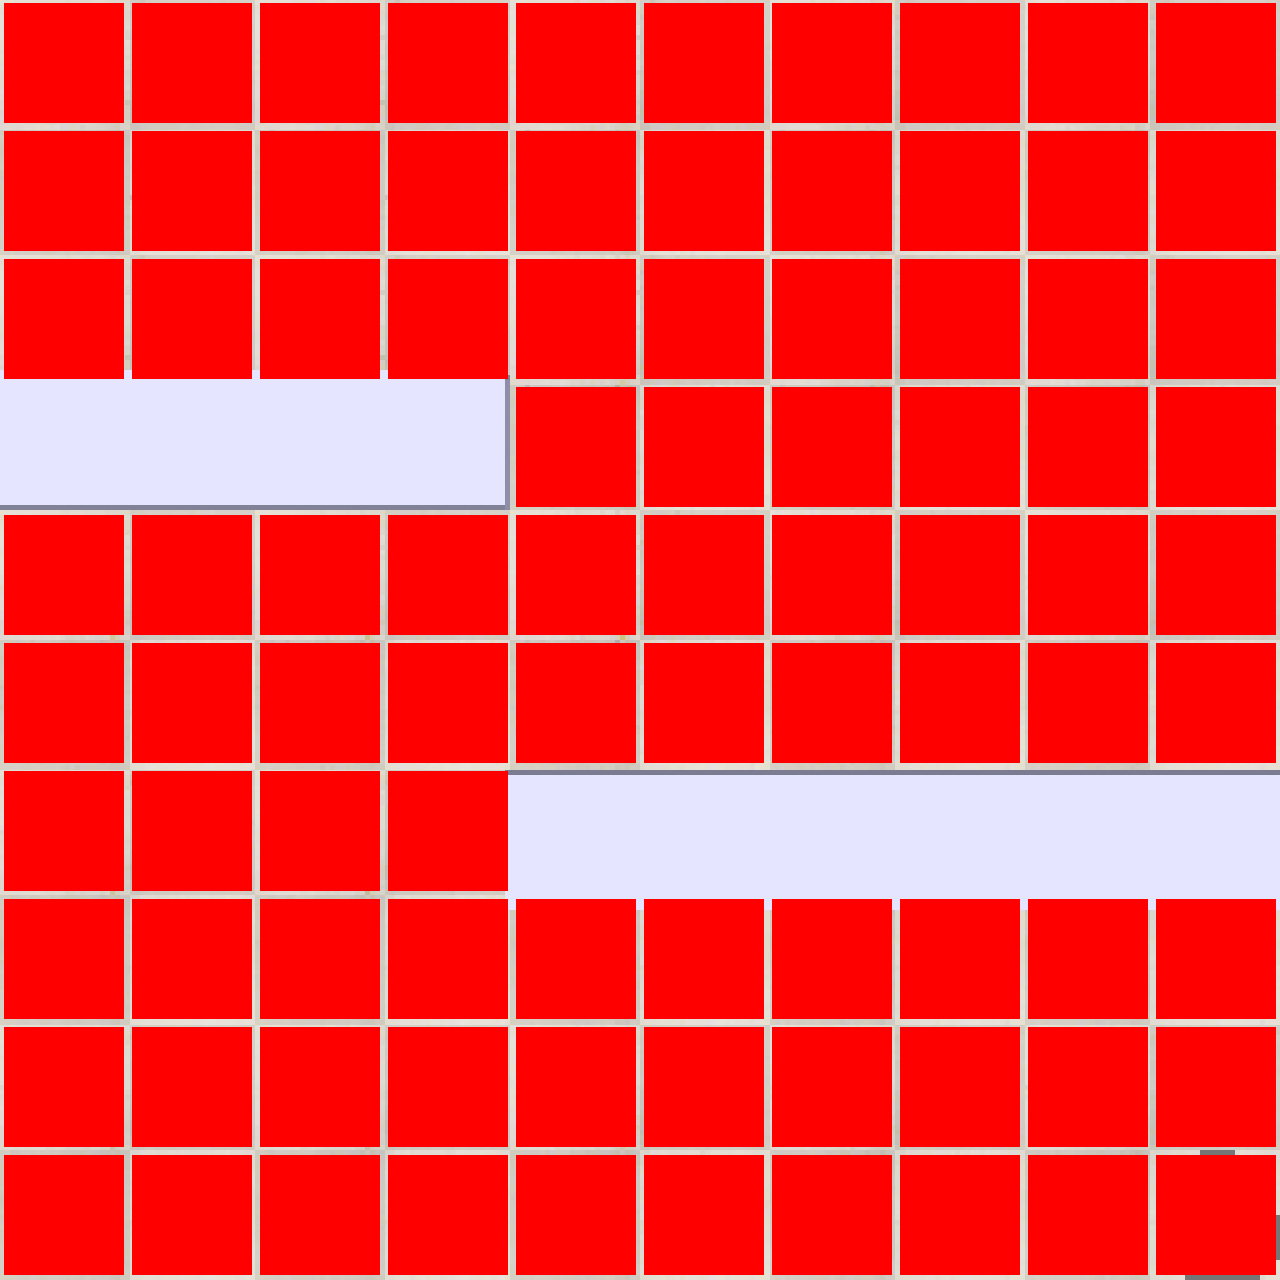

In [79]:
image_pp = Image.fromarray(resized)
image_pp




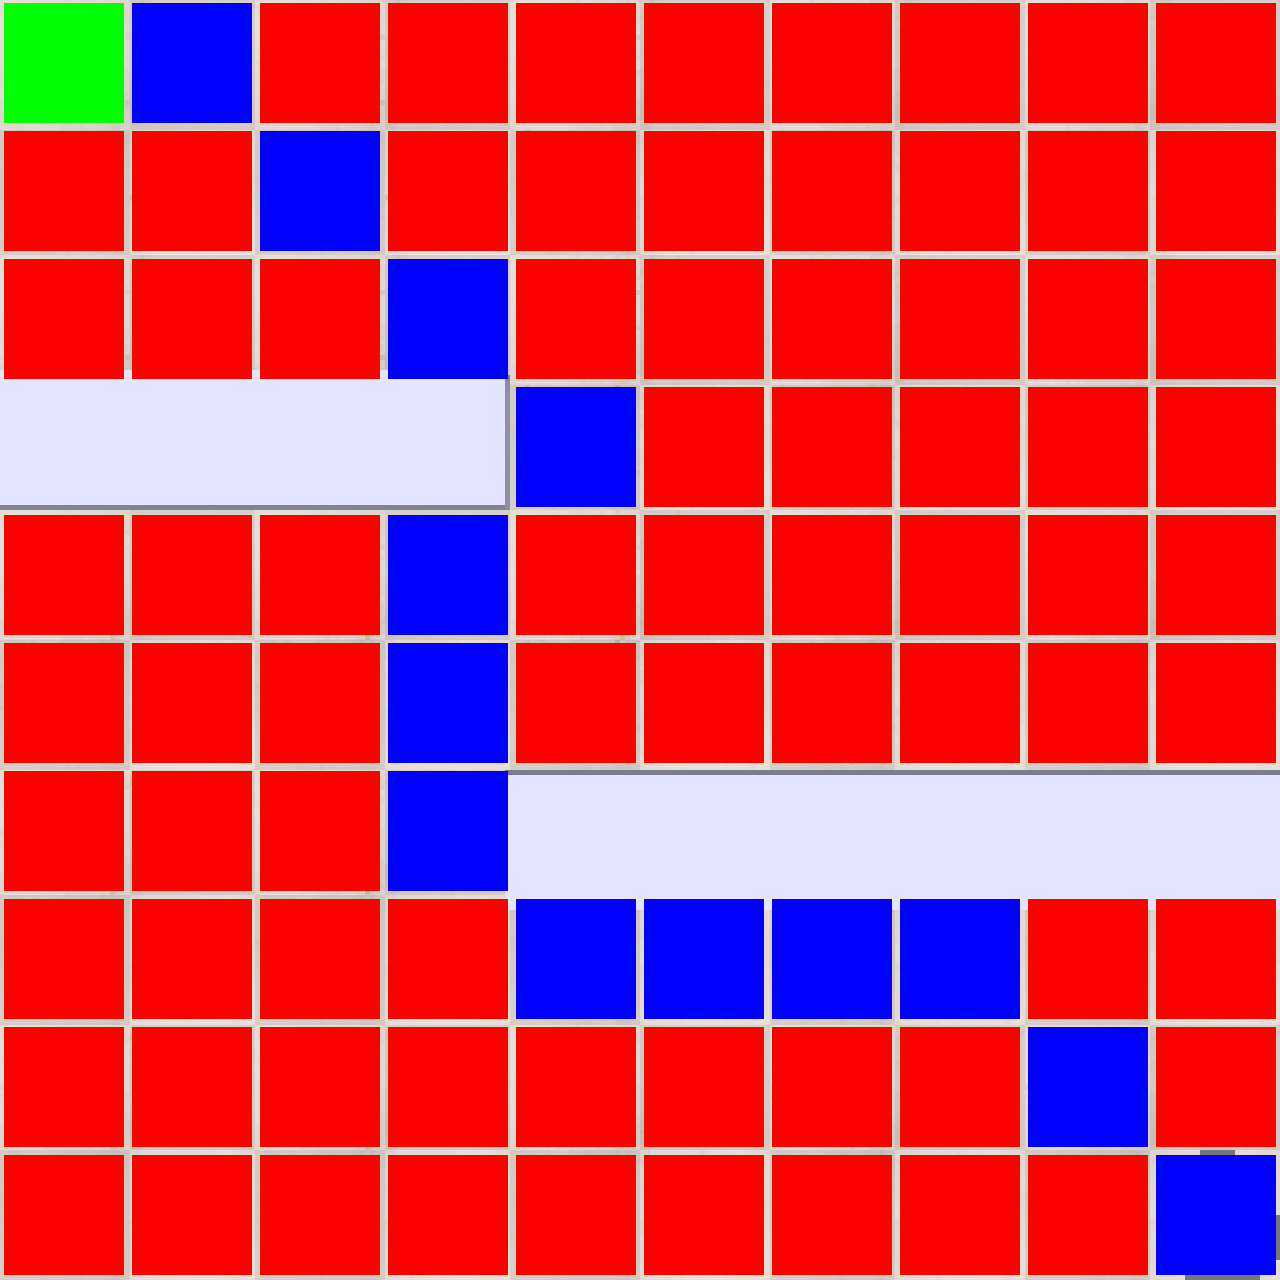

In [8]:
cccc=ccc[1:]
for i in cccc:
    draw_rec_blue(i,resized)
draw_rec_green(ccc[-1],resized)
image_pp = Image.fromarray(resized)
image_pp
